In [1]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.5 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.callbacks import EarlyStopping

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/w266_project')
df = pd.read_csv("features.csv", header = 0, sep="\t", index_col=0)

In [5]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a 

In [6]:
big_countries = ['USA', 'Germany' 'Japan', 'Sweden', 'UK', 'Canada', 'Italy', 'Switzerland', 'France', 'China', 'Belgium', 'Netherlands', 'Australia', 'Spain',
'Poland', 'Austria', 'Denmark', 'Hungary','India','Finland','Taiwan', 'South Korea','Russia' ,'Czech Rep.']

df['Auth_country'] = df['Auth_country'].apply(lambda x: x if x in big_countries else 'other')

In [7]:
df['Abstract'] = df['Document Title'] + df['Abstract']

In [8]:
X = df[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words', 'Funding','Auth_country', 'Pub_country', 'Abstract']]
y = df['JIF']

train_idx, val_idx, y_train, y_val = train_test_split(range(len(df)), y, test_size=0.3, random_state=42)

In [9]:
# Prepare categorical data
categories = ['Funding','Auth_country', 'Pub_country']
train_one_hot_data = {}
val_one_hot_data = {}
for cat in categories:
  one_hot_df = pd.get_dummies(df[cat], prefix=cat, dtype=int)
  train_one_hot_data[cat] = one_hot_df.iloc[train_idx]
  val_one_hot_data[cat] = one_hot_df.iloc[val_idx]

# Prepare numerical data
num_data = X[['Year Published', 'Cited Reference Count', 'Page Count', 'num_auth', 'num_words']]
scaler  = MinMaxScaler(feature_range=(0,1))
num_data = scaler.fit_transform(num_data)
train_num_data = num_data[train_idx]
val_num_data = num_data[val_idx]

### Model with text and metadata

In [10]:
max_length = 400
train_encodings = bert_tokenizer(list(X['Abstract'].iloc[train_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = bert_tokenizer(list(X['Abstract'].iloc[val_idx]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [11]:
hidden_size = 768 + 5 + 49 + 10 + 1
dropout = 0.3
learning_rate = 0.0001

num_of_levels  = df['Funding'].nunique()
#Jeremy Howard provides the following rule of thumb; embedding size = min(50, number of categories/2).
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Funding embeding size: {embedding_size}')

fund_input = keras.layers.Input(shape=(num_of_levels,), name = 'fund_input')
fund_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'fund_emb')(fund_input)
fund_flat = keras.layers.Flatten(name = 'fund_flat')(fund_emb)
fund_flat = tf.keras.layers.Dropout(dropout)(fund_flat)

num_of_levels  = df['Auth_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Auth cont embeding size: {embedding_size}')

Auth_input = keras.layers.Input(shape=(num_of_levels,), name = 'Auth_input')
Auth_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Auth_emb')(Auth_input)
Auth_flat = keras.layers.Flatten(name = 'Auth_flat')(Auth_emb)
Auth_flat = tf.keras.layers.Dropout(dropout)(Auth_flat)

num_of_levels  = df['Pub_country'].nunique()
embedding_size = min(np.ceil((num_of_levels)/2), 50 )
embedding_size = int(embedding_size)
print(f'Pub cont embeding size: {embedding_size}')

Pub_input = keras.layers.Input(shape=(num_of_levels,), name = 'Pub_input')
Pub_emb = keras.layers.Embedding(input_dim=num_of_levels, output_dim=embedding_size, name = 'Pub_emb')(Pub_input)
Pub_flat = keras.layers.Flatten(name = 'Pub_flat')(Pub_emb)
Pub_flat = tf.keras.layers.Dropout(dropout)(Pub_flat)

inp_num_data = keras.layers.Input(shape=(num_data.shape[1],), name = 'Num feat')

#Set up the BERT part of the model
bert_model.trainable = False
# BERT inputs
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')
bert_inputs = {'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask}
bert_out = bert_model(bert_inputs)
tokens = bert_out[0][:,0,:] #cls token

# Concatenate all layers
conc = keras.layers.Concatenate()([tokens, Auth_flat, Pub_flat, fund_flat, inp_num_data])

hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(conc)
hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

# Create output layer
out = keras.layers.Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask,
                            Auth_input, Pub_input, fund_input,
                            inp_num_data], outputs=out)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])

Funding embeding size: 1
Auth cont embeding size: 12
Pub cont embeding size: 10


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Auth_input (InputLayer)     [(None, 23)]                 0         []                            
                                                                                                  
 Pub_input (InputLayer)      [(None, 20)]                 0         []                            
                                                                                                  
 fund_input (InputLayer)     [(None, 2)]                  0         []                            
                                                                                                  
 attention_mask_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                      

In [13]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

model.fit([ train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask,
           train_one_hot_data['Auth_country'], train_one_hot_data['Pub_country'], train_one_hot_data['Funding'],
           train_num_data],
           y_train,
           validation_data=([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                            val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                            val_num_data],
                            y_val),
           batch_size=128, epochs=60, callbacks=[early_stopping])

Epoch 1/60
25/25 [==============================] - 59s 2s/step - loss: 10.3939 - mean_squared_error: 10.3939 - val_loss: 5.0452 - val_mean_squared_error: 5.0452
Epoch 2/60
25/25 [==============================] - 42s 2s/step - loss: 4.4371 - mean_squared_error: 4.4371 - val_loss: 3.9592 - val_mean_squared_error: 3.9592
Epoch 3/60
25/25 [==============================] - 42s 2s/step - loss: 3.9361 - mean_squared_error: 3.9361 - val_loss: 3.6616 - val_mean_squared_error: 3.6616
Epoch 4/60
25/25 [==============================] - 42s 2s/step - loss: 3.7253 - mean_squared_error: 3.7253 - val_loss: 3.5061 - val_mean_squared_error: 3.5061
Epoch 5/60
25/25 [==============================] - 42s 2s/step - loss: 3.5886 - mean_squared_error: 3.5886 - val_loss: 3.4145 - val_mean_squared_error: 3.4145
Epoch 6/60
25/25 [==============================] - 42s 2s/step - loss: 3.5181 - mean_squared_error: 3.5181 - val_loss: 3.3424 - val_mean_squared_error: 3.3424
Epoch 7/60
25/25 [====================

In [14]:
pred = model.predict([val_encodings.input_ids, val_encodings.token_type_ids, val_encodings.attention_mask,
                      val_one_hot_data['Auth_country'], val_one_hot_data['Pub_country'], val_one_hot_data['Funding'],
                      val_num_data])

43/43 [==============================] - 15s 289ms/step


Text(0, 0.5, 'Observed')

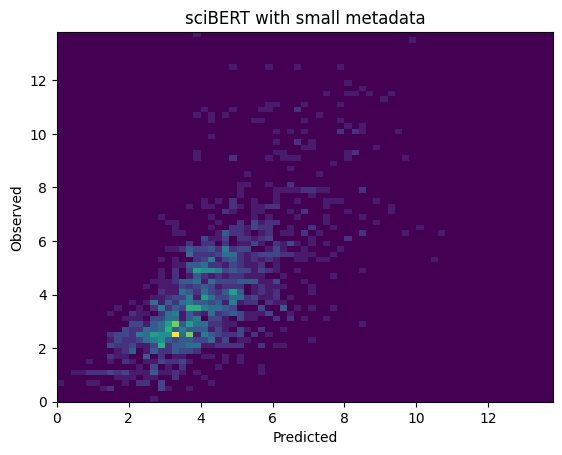

In [15]:
predictions = pred.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, y_val , bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_title('sciBERT with small metadata')
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')

In [16]:
np.corrcoef(predictions, y_val)

array([[1.        , 0.68510767],
       [0.68510767, 1.        ]])

In [17]:
df_to_save = pd.DataFrame({'Observed':y_val, 'Predicted':predictions})
p = os.path.abspath('.')
file_path = os.path.join(p, 'results_csv', 'scibert_title_smallmeta.csv')
df_to_save.to_csv(file_path, sep = '\t')